In [372]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/Desktop/OptimalC/Project/16745-threebody/src/Project.toml`


In [381]:
using LinearAlgebra
# using PyPlot
using Plots
using ForwardDiff
using RobotZoo
using RobotDynamics
using Ipopt
using MathOptInterface
# Pkg.add("MATLAB")
using MATLAB 
include("Non_lin_exp.jl")
include("CR3BP_Dynamics.jl")
const MOI = MathOptInterface;

In [382]:
Nx = 6     # number of state
Nu = 1     # number of controls
Tfinal = pi # final time-50 knot points or something similar 
Nt = 50   # number of time steps-52
h = Tfinal/(Nt-1) 
thist = Array(range(0,Tfinal, step=h));#0:pi,step: 0.06 
n_nlp = (Nx+Nu)*Nt # number of decision variables-350
m_nlp = Nx*(Nt+1) #306
u_idx = [(Nx+Nu)*(i-1) .+ (Nx+1:Nx+Nu) for i = 1:Nt];
x_idx = [(Nx+Nu)*(i-1) .+ (1:Nx) for i = 1:Nt];
@show h

h = 0.0641141357875468


0.0641141357875468

In [383]:
#Calc of Reference Trajectory 
Xref =[zeros(Nx) for i=1:Nt];
for k = 1:Nt
    Pos = Non_lin_exp(thist[k]);
    # Pos = lin_approx(thist[k]);
    Xref[k][1] = Pos[1];
    Xref[k][2] = Pos[2];
    Xref[k][3] = Pos[3];
    Vels = ForwardDiff.derivative(Non_lin_exp,thist[k]);
    # Vels = ForwardDiff.derivative(lin_approx,thist[k]);
    Xref[k][4] = Vels[1];
    Xref[k][5] = Vels[2];
    Xref[k][6] = Vels[3];
end
Uref = h*ones(Nt);

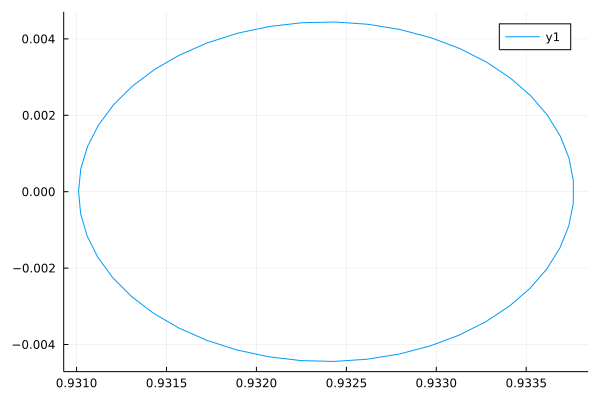

In [384]:
xRef = zeros(Nt)
yRef = zeros(Nt)
zRef = zeros(Nt)

for k = 1:Nt
    xRef[k] = Xref[k][1]
    yRef[k] = Xref[k][2]
    zRef[k] = Xref[k][3]
end

Plots.plot(xRef,yRef)

In [385]:
function dircol_dynamics(x1,x2,h)
    #Hermite-Simpson integration with first-order hold on u
    f1 = CR3BPdynamics(x1) #Timestep k
    f2 = CR3BPdynamics(x2) #Timestep k+1
    xm = 0.5.*(x1 + x2) .+ (h/8.0).*(f1 - f2) #
    ẋm = (-3.0/(2.0*h)).*(x1 - x2) .- 0.25.*(f1 + f2)
    fm = CR3BPdynamics(xm)
    return fm - ẋm
end

dircol_dynamics (generic function with 1 method)

In [386]:
# Cost weights
Q = Diagonal([0.85*10e8*ones(3); 0.85*10e8*ones(3)]);
R = 0.001;

In [387]:
function stage_cost(x,u,Xref,Uref)
    return 0.5*((x.-Xref)'*Q*(x.-Xref)) + 0.5*(u.-Uref)'*R*(u.-Uref)
end

stage_cost (generic function with 1 method)

In [388]:
function cost(ztraj)
    z = reshape(ztraj,Nx+Nu,Nt)
    J = 0.0
    for k = 1:Nt
        J += stage_cost(z[1:Nx,k],z[(Nx+1):(Nx+Nu),k],Xref[k],Uref[k])
    end
    return J
end

cost (generic function with 1 method)

In [389]:
function dynamics_constraint!(c,ztraj)
    d = reshape(c,Nx,Nt) # c[6,50] = 300
    z = reshape(ztraj,Nx+Nu,Nt) #ztraj[7,50]
    for k = 1:(Nt-1)
        x1 = z[1:Nx,k]
        u1 = z[(Nx+1):(Nx+Nu),k]
        x2 = z[1:Nx,k+1]
        d[:,k] = dircol_dynamics(x1,x2,u1)
    end
    return nothing
end

dynamics_constraint! (generic function with 1 method)

In [390]:
function con!(c,ztraj)
    z = reshape(ztraj,Nx+Nu,Nt)#7 x 50
    @views dynamics_constraint!(c[1:(end-Nx)],ztraj) #6 x 50 
    #Periodicity Constraint 
    c[(end-Nx+1):end] .= z[1:Nx,end] - z[1:Nx,1]
end

con! (generic function with 1 method)

In [391]:
struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=(1:0),
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

#Our code 
function primal_bounds(n)
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n) #+_ 20% dt_ref
    for k = 1:Nt
        x_l[u_idx[k]] .= h*0.01 #Something reasonable based on dt_ref 0.8*dt
        x_u[u_idx[k]] .= h*(1.5)
    end 

    return x_l, x_u
end

#Our code 
function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)
    c_u = zeros(m)
    return c_l, c_u
end
#Our code 

function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,cost,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(g,x)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), con!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-9,c_tol=1.0e-9,max_iter=10000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

solve (generic function with 1 method)

In [392]:
#Guess
z0 = zeros((Nx+Nu)*(Nt))
# z0[x_idx[1]] = Xref[1]
for k=1:Nt
    z0[x_idx[k]] = Xref[k]
    z0[u_idx[k]] .= Uref[k]
end

In [393]:
prob = ProblemMOI(n_nlp,m_nlp)
z_sol = solve(z0,prob) # solve

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   107100
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      350
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total number of equality constraints.................:      306
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

350-element Vector{Float64}:
  0.9311380871447567
  0.0007850301137386309
  0.000132294155026959
  0.0005462794079901142
  0.009203795983335882
 -0.00018724073974271246
  0.000641141357875468
  0.9311384386944836
  0.0007909301982152682
  0.0001321739900042857
  ⋮
 -0.00012636240865865166
  0.022038441629533476
  0.9311390053263668
  0.0007773593063168001
  0.00014785814217919464
  0.0005447241389999687
  0.00920475028782071
 -0.00014037977591400575
  0.04835691732035115

In [394]:
ztraj = reshape(z_sol,Nx+Nu,Nt);
xtraj = ztraj[1:Nx,:];#6 x 91
utraj = ztraj[(Nx+1):(Nx+Nu),:]; # 1 x 91
@show utraj

utraj = [0.000641141357875468 0.03710193191843741 0.07379850772352123 0.06887306907384805 0.04106875701032615 0.06773508454078808 0.06252526069906238 0.06025330973844604 0.05925744971320884 0.05952950138015351 0.06005696118809412 0.06031690778893811 0.060179829521841 0.059849994328364665 0.05947833310867593 0.05927009917442993 0.059331280885295795 0.05939093493545739 0.059622481941277145 0.0603706994419865 0.06199290696477028 0.06482716125341584 0.06795892649229497 0.06930470912030938 0.06786070578501975 0.06455462577012612 0.061778497572631076 0.06021929869221618 0.059580408315108475 0.05927746156430379 0.05912734485213099 0.059155374302010316 0.05927326110709919 0.05943202051977926 0.05946547897485962 0.059667430013502984 0.060017983890577845 0.06056747460349761 0.060897378374130555 0.06105367341215996 0.06082231186929149 0.0594895748308248 0.06196644936514144 0.06928515050440416 0.061655943479995 0.06534601078920818 0.06524526854040168 0.055102555597462126 0.022038441629533476 0.048

1×50 Matrix{Float64}:
 0.000641141  0.0371019  0.0737985  …  0.0551026  0.0220384  0.0483569

In [395]:
xtraj
# p = Plots.plot(xRef,yRef)
# Plots.plot!(p,xtraj[1,:],xtraj[2,:])
# Plots.plot(xtraj[1,:],xtraj[2,:])
# Plot(thist,xtraj[2,:])
# Plot(thist,xguess[1,:])
# PyPlot.show()

6×50 Matrix{Float64}:
  0.931138      0.931138      0.931163     …   0.931129      0.931139
  0.00078503    0.00079093    0.00112939       0.000573651   0.000777359
  0.000132294   0.000132174   0.000124826      0.000150818   0.000147858
  0.000546279   0.000550376   0.000784959      0.000402948   0.000544724
  0.0092038     0.00920144    0.00903501       0.00927451    0.00920475
 -0.000187241  -0.000187604  -0.000208125  …  -0.000126362  -0.00014038

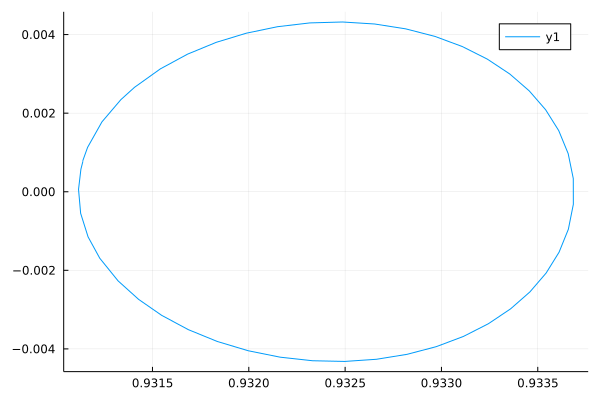

In [396]:
Plots.plot(xtraj[1,:],xtraj[2,:])
# Plots.plot(thist,xtraj[3,:])
# PyPlot.show()

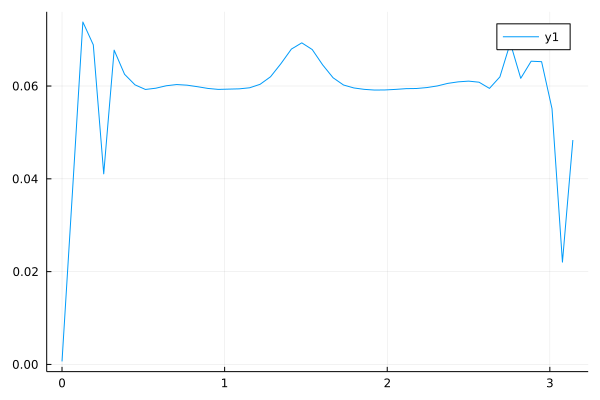

In [397]:
Plots.plot(thist,utraj[1,:])

In [423]:
xTraj = zeros(Nt)
yTraj = zeros(Nt)
zTraj = zeros(Nt)

for k = 1:Nt
    xTraj[k] = xtraj[1,k]
    yTraj[k] = xtraj[2,k]
    zTraj[k] = xtraj[3,k]
end

Plots.plot(xRef,yRef)
mat"""
plot3($xTraj,$yTraj,$zTraj,'DisplayName','IPOPT')
hold on 
plot3($xRef,$yRef,$zRef,'DisplayName','Reference')
legend('IPOPT','Reference')
""" 
# plot3($xtraj[1,:],$xtraj[2,:],$xtraj[3,:])



In [422]:
mat"""
plot($yTraj,$zTraj,'DisplayName','IPOPT')
hold on 
plot($yRef,$zRef,'DisplayName','Reference')

legend('IPOPT','Reference')
""" 

In [407]:
z_sol2 = solve(z_sol,prob) # solve

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   107100
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      350
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total number of equality constraints.................:      306
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

350-element Vector{Float64}:
  0.9311277764443266
  0.0005908764672377078
  4.2424514572142375e-11
  0.00041138515781914014
  0.00927221478257842
  1.5687387722146675e-8
  0.0008244280680196988
  0.9311281177856474
  0.000598519800530939
  5.534060844904004e-11
  ⋮
  1.5457820453070182e-8
  0.002104396084246067
  0.9311277764521403
  0.0005908762685132501
 -1.4096519096216662e-9
  0.0004113851107949338
  0.009272214800984252
  1.5470694201265823e-8
  0.048359810653657576

In [410]:
ztraj_ = reshape(z_sol2,Nx+Nu,Nt);
xtraj_ = ztraj_[1:Nx,:];#6 x 91
utraj_ = ztraj_[(Nx+1):(Nx+Nu),:]; # 1 x 91

In [411]:
xTraj_ = zeros(Nt)
yTraj_ = zeros(Nt)
zTraj_ = zeros(Nt)

for k = 1:Nt
    xTraj_[k] = xtraj_[1,k]
    yTraj_[k] = xtraj_[2,k]
    zTraj_[k] = xtraj_[3,k]
end

In [413]:
mat"""
plot3($xTraj,$yTraj,$zTraj,'DisplayName','IPOPT1')
hold on 
plot3($xTraj_,$yTraj_,$zTraj_,'DisplayName','IPOPT2')
plot3($xRef,$yRef,$zRef,'DisplayName','Reference')
legend('IPOPT','IPOPT2','Reference')
""" 

In [418]:
mat"""
plot($yTraj,zTraj,'DisplayName','IPOPT1')
hold on 
plot($yTraj_,$zTraj_,'DisplayName','IPOPT2')

legend('IPOPT1','IPOPT2')
""" 

>> >> >> >> >> >> >> [Warning: Ignoring extra legend entries.] 
[> In legend>process_inputs (line 587)
In legend>make_legend (line 315)
In legend (line 259)] 


{Unrecognized function or variable 'zTraj'.
} 
